In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import zipfile
import pandas as pd
from PIL import Image
import random

# Dataset download

In [19]:
ROOT_PATH = os.path.join("..", "data", "raw")
DATASET_PATH = os.path.join(ROOT_PATH, "Garbage_Dataset_Classification")
ZIP_FILE = os.path.join(ROOT_PATH, "garbage-dataset.zip")

# Direct Kaggle download link
KAGGLE_URL = "https://www.kaggle.com/api/v1/datasets/download/zlatan599/garbage-dataset-classification"

In [20]:
def download_with_curl():
    """
    Download Kaggle dataset using curl + API credentials.
    Requires: ~/.kaggle/kaggle.json with username + key
    """
    print("Downloading dataset with curl...")

    # Make sure ~/.kaggle exists and is secure
    os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
    os.chmod(os.path.expanduser("~/.kaggle"), 0o700)

    # Run curl command (requires kaggle.json for auth)
    cmd = f"curl -L -o {ZIP_FILE} -u `jq -r .username ~/.kaggle/kaggle.json`:`jq -r .key ~/.kaggle/kaggle.json` {KAGGLE_URL}"
    os.system(cmd)

    print("Extracting dataset...")
    with zipfile.ZipFile(ZIP_FILE, "r") as zip_ref:
        zip_ref.extractall(ROOT_PATH)
    
    os.remove(ZIP_FILE)

In [21]:
if not os.path.exists(DATASET_PATH):
    download_with_curl()
else:
    print(f"{DATASET_PATH} already exists, nothing to do.")

../data/raw/Garbage_Dataset_Classification already exists, nothing to do.


# Dataset exploration

## Dataset folder structure

In [22]:
for root, dirs, files in os.walk(DATASET_PATH):
    print(root, len(files))

../data/raw/Garbage_Dataset_Classification 1
../data/raw/Garbage_Dataset_Classification/images 0
../data/raw/Garbage_Dataset_Classification/images/metal 2084
../data/raw/Garbage_Dataset_Classification/images/paper 2315
../data/raw/Garbage_Dataset_Classification/images/plastic 2288
../data/raw/Garbage_Dataset_Classification/images/glass 2500
../data/raw/Garbage_Dataset_Classification/images/trash 2500
../data/raw/Garbage_Dataset_Classification/images/cardboard 2214


## Metadata

In [29]:
# Load metadata
metadata_path = os.path.join(DATASET_PATH, "metadata.csv")
df = pd.read_csv(metadata_path)

# Quick look at the data
print(df.head())
print()
print(df['label'].value_counts())

              filename      label
0  cardboard_02038.jpg  cardboard
1  cardboard_02320.jpg  cardboard
2  cardboard_01728.jpg  cardboard
3  cardboard_00093.jpg  cardboard
4  cardboard_00094.jpg  cardboard

label
glass        2500
trash        2500
paper        2315
plastic      2288
cardboard    2214
metal        2084
Name: count, dtype: int64


## Sample visualization

In [35]:
def plot_random_examples_per_class(df, dataset_path):
    """
    Plots a random image from each class with colored borders using seaborn palette.
    """
    classes = df['label'].unique()
    n_classes = len(classes)
    
    # Seaborn palette for consistent class colors
    palette = sns.color_palette("tab10", n_classes)
    class_colors = {cls: palette[i] for i, cls in enumerate(classes)}
    
    # Determine grid size
    cols = 3
    rows = (n_classes + cols - 1) // cols
    plt.figure(figsize=(cols*4, rows*4))
    
    for i, cls in enumerate(classes):
        img_filename = df[df['label']==cls].sample(1).iloc[0]['filename']
        img_path = os.path.join(dataset_path, "images", cls, img_filename)
        img = Image.open(img_path)
        
        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(img)
        ax.set_title(cls, fontsize=14, color=class_colors[cls])
        ax.axis("off")
        
        # Add colored border
        for spine in ax.spines.values():
            spine.set_edgecolor(class_colors[cls])
            spine.set_linewidth(4)
    
    plt.tight_layout()
    plt.show()

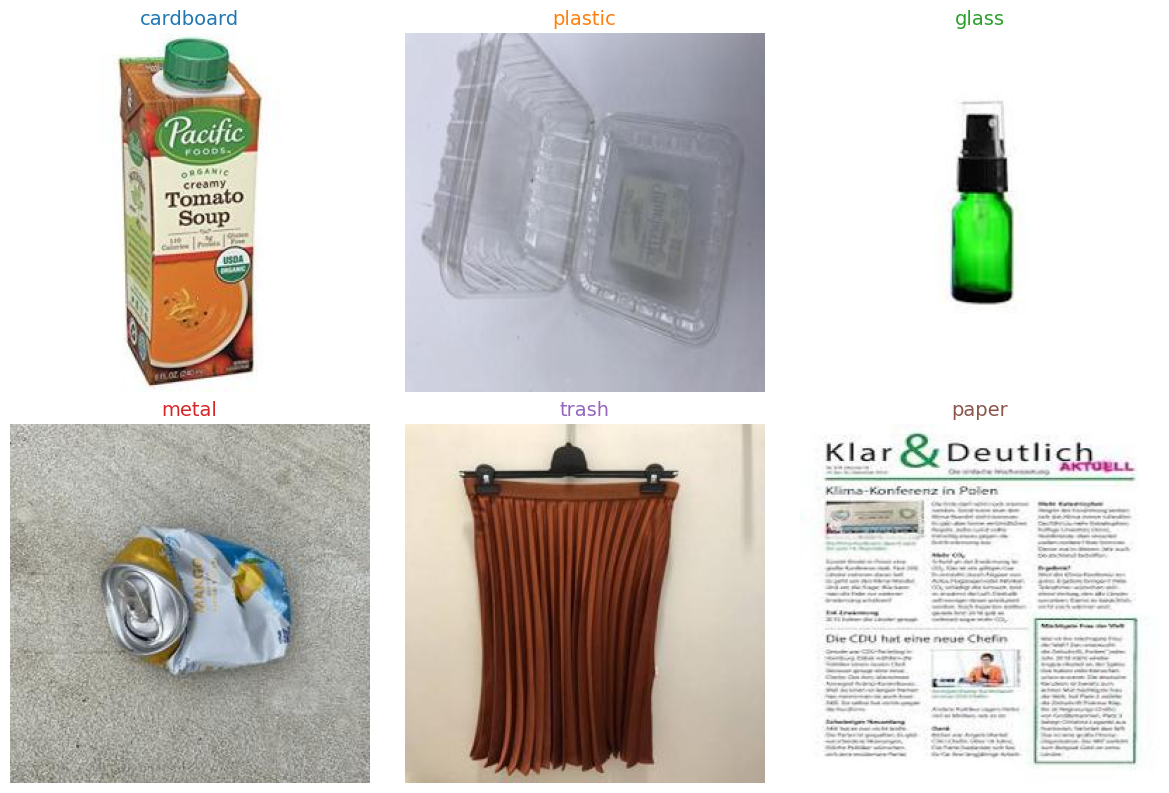

In [36]:
plot_random_examples_per_class(df, DATASET_PATH)